# 1. 加载数据

## 1.1 导入库及下载数据

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_set = torchvision.datasets.CIFAR10(root='../../data', train=True, download=False, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=2)
test_set = torchvision.datasets.CIFAR10(root='../../data', train=False, download=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## 1.2 随机查看部分数据

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [4]:
# 显示图像
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [5]:
# 随机获取部分训练数据
dataiter = iter(train_loader)
images, labels = dataiter.next()

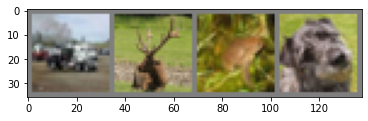

truck  deer  frog   dog


In [6]:
# 显示图像
imshow(torchvision.utils.make_grid(images))
# 显示标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# 2. 构建网络

## 2.1 构建网络

In [7]:
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [22]:
class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 36, 3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(1296, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 36*6*6)
        x = F.relu(self.fc2(F.relu(self.fc1(x))))
        return x


class Net(nn.Module):
    """采用全局平均池化"""
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 36, 5)
        # self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.pool2 = nn.MaxPool2d(2, 2)
        # 使用全局平均池化层
        self.aap = nn.AdaptiveAvgPool2d(1)
        self.fc3 = nn.Linear(36, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.aap(x)
        x = x.view(x.shape[0], -1)
        x = self.fc3(x)
        return x

In [23]:
net = Net()
net = net.to(device)

## 2.2 查看网络结构

In [24]:
# 显示网络中定义了哪些层
print(net)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 36, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (aap): AdaptiveAvgPool2d(output_size=1)
  (fc3): Linear(in_features=36, out_features=10, bias=True)
)


## 2.3 查看网络中前几层

In [25]:
# 取模型中的前四层
nn.Sequential(*list(net.children())[:4])

Sequential(
  (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(16, 36, kernel_size=(5, 5), stride=(1, 1))
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

# 3. 训练模型

## 3.1 选择优化器

In [26]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 3.2 训练模型

In [27]:
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # 获取训练数据
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # 权重参数梯度清零
        optimizer.zero_grad()

        # 正向及反向传播
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 显示损失值
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{(epoch + 1)}, {(i+1):5d}] loss: {(running_loss / 2000):.3f}')
            running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 2.117
[1,  4000] loss: 1.820
[1,  6000] loss: 1.741
[1,  8000] loss: 1.683
[1, 10000] loss: 1.627
[1, 12000] loss: 1.572
[2,  2000] loss: 1.511
[2,  4000] loss: 1.481
[2,  6000] loss: 1.450
[2,  8000] loss: 1.419
[2, 10000] loss: 1.415
[2, 12000] loss: 1.373
[3,  2000] loss: 1.345
[3,  4000] loss: 1.339
[3,  6000] loss: 1.324
[3,  8000] loss: 1.285
[3, 10000] loss: 1.297
[3, 12000] loss: 1.270
[4,  2000] loss: 1.258
[4,  4000] loss: 1.245
[4,  6000] loss: 1.231
[4,  8000] loss: 1.216
[4, 10000] loss: 1.199
[4, 12000] loss: 1.218
[5,  2000] loss: 1.205
[5,  4000] loss: 1.153
[5,  6000] loss: 1.195
[5,  8000] loss: 1.152
[5, 10000] loss: 1.154
[5, 12000] loss: 1.127
[6,  2000] loss: 1.145
[6,  4000] loss: 1.111
[6,  6000] loss: 1.118
[6,  8000] loss: 1.104
[6, 10000] loss: 1.115
[6, 12000] loss: 1.099
[7,  2000] loss: 1.060
[7,  4000] loss: 1.098
[7,  6000] loss: 1.063
[7,  8000] loss: 1.081
[7, 10000] loss: 1.070
[7, 12000] loss: 1.081
[8,  2000] loss: 1.051
[8,  4000] 

# 4. 测试模型

In [28]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

Accuracy of the network on the 10000 test images: 63.85 %


In [29]:
# 各种类别的准确率
class_correct = list(0. for _ in range(10))
class_total = list(0. for _ in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

In [30]:
for i in range(10):
    print(f'Accuracy of {classes[i]:>5s} : {(100 * class_correct[i] / class_total[i]):.2f} %')

Accuracy of plane : 66.00 %
Accuracy of   car : 72.90 %
Accuracy of  bird : 53.40 %
Accuracy of   cat : 42.00 %
Accuracy of  deer : 48.20 %
Accuracy of   dog : 40.90 %
Accuracy of  frog : 85.50 %
Accuracy of horse : 75.90 %
Accuracy of  ship : 75.60 %
Accuracy of truck : 78.10 %


In [31]:
# 显示模型参数总量
print(f"net_gvp have {sum(x.numel() for x in net.parameters())} parameters in total.")

net_gvp have 16022 parameters in total.
